# Tarea 1 IMT2112 - Clemente Wacquez
---


### Pregunta 1
El cuaderno compilado se encuentra adjunto como `ejecucion.ipynb`. Se utilizaron 20.000 registros y $k=7$

---

### Pregunta 2 
El código presentado no tiene ninguna implementación de paralelismo. Esto puede deducirse dado que python no puede realizar paralelismo con sus librerias estándar y no se importa ninguna librería adicional que permita realizar paralelismo en el código.

---

### Pregunta 3
Copiamos las celdas que nos permiten generar los datos

In [1]:
import numpy as np
from scipy.spatial.distance import cdist

In [2]:
from sklearn.datasets import make_blobs
n_points = 20_000
n_clusters = 3
np.random.seed(0)
dataset, _ = make_blobs(n_samples=n_points, n_features=2, centers=n_clusters)
print("Created a dataset that represents", n_clusters, "clusters in", dataset.shape[1], "dimensions.")

Created a dataset that represents 3 clusters in 2 dimensions.


In [3]:
k = 7
centers = np.zeros([k, 2])
for c in range(k):
    centers[c,0] = float(c+1)/(k+1)
    centers[c,1] = 0.0

max_iterations = 1000

A continuación, definiremos dos funciones: `k_medidas` y `k_medidas_numpy`, la primera corresponde a la implementación del algoritmo de $k$-medidas que se entregó de ejemplo y la segunda la reimplementación utilizando funciones de la librería `numpy` . Las porciones con código modificado se encuentran comentadas con `##`.

In [4]:
def k_medias(data, k, verbosity=False):
    
    centers = np.zeros([k, 2])
    for c in range(k):
        centers[c,0] = float(c+1)/(k+1)
        centers[c,1] = 0.0
    
    max_iterations = 1000
    
    # store the history of centers and clusters
    history_of_centers = [centers]
    history_of_clusters = []
    
    for iteration in range(max_iterations):
        
        old_centers = history_of_centers[-1]
    
        # assignment step
        cluster = np.zeros(n_points, dtype='int')
        for p in range(n_points):
            minimum_distance = np.inf
            nearest_cluster = None
            for c in range(k):
                distance_to_cluster_c = np.sqrt((data[p,0] - old_centers[c,0])**2 + (data[p,1] - old_centers[c,1])**2)
                if distance_to_cluster_c < minimum_distance:
                    minimum_distance = distance_to_cluster_c
                    nearest_cluster = c
            cluster[p] = nearest_cluster
        history_of_clusters.append(cluster)
        
        # check convergence
        if iteration > 0:
            clusters_changed = False
            for p in range(n_points):
                if history_of_clusters[-1][p] != history_of_clusters[-2][p]:
                    clusters_changed = True
            if not clusters_changed:
                if verbosity:
                    print("Converged in", iteration, "iterations.\n")
                break
    
        # update step
        number_of_points_in_cluster = np.zeros(k, dtype='int')
        sum_of_locations = np.zeros([k, 2], dtype='float')
        for p in range(n_points):
            number_of_points_in_cluster[cluster[p]] += 1
            sum_of_locations[cluster[p], :] += data[p, :]
        new_centers = np.zeros([k, 2], dtype='float')
        for c in range(k):
            new_centers[c,0] = sum_of_locations[c,0] / number_of_points_in_cluster[c]
            new_centers[c,1] = sum_of_locations[c,1] / number_of_points_in_cluster[c]
        history_of_centers.append(new_centers)
    
    if iteration == max_iterations-1:
        if verbosity:
            print("The algorithm did not converge in", max_iterations, "iterations.")

    else:
        return history_of_clusters[-1], history_of_centers[-1]

In [5]:
def k_medias_numpy(data, k, verbosity=False):
    
    centers = np.zeros([k, 2])
    for c in range(k):
        centers[c,0] = float(c+1)/(k+1)
        centers[c,1] = 0.0
    
    max_iterations = 1000
    
    # store the history of centers and clusters
    ## Cambiamos los tipos de los historiales a np.array
    history_of_centers = np.array([centers])
    history_of_clusters = np.empty((0, n_points))
    
    for iteration in range(max_iterations):
        
        old_centers = history_of_centers[-1]
    
        # assignment step
        ## Calculamos las distancias que hay entre los registros y los centros utilizando cdist
        dist_matrix = cdist(data, old_centers)

        ## Obtenemos el array `cluster` calculando los índices en que se encuentra el mínimo de
        ## cada fila de la matriz `dist_matrix`
        cluster = np.argmin(dist_matrix, axis = 1)
        
        history_of_clusters = np.vstack([history_of_clusters, cluster])
    
        if iteration > 0:
            clusters_changed = False
            ## Chequeamos si los clusters cambiaron utilizando np.array_equal
            if not np.array_equal(history_of_clusters[-1], history_of_clusters[-2]):
                clusters_changed = True
            if not clusters_changed:
                if verbosity:
                    print("Converged in", iteration, "iterations.\n")
                break
    
        # update step
        ## Eliminamos el loop utilizando la función np.mean y el hecho que el arreglo `cluster==center`
        ## nos entregará los valores en el data que pertenecen al centro `center`
        new_centers = np.array([np.mean(data[cluster == center], axis=0) for center in range(k)])
        history_of_centers = np.append(history_of_centers, [new_centers], axis=0)
    
    if iteration == max_iterations-1:
        if verbosity:
            print("The algorithm did not converge in", max_iterations, "iterations.")
    else:
        return history_of_clusters[-1], history_of_centers[-1]

En la pregunta 4 se puede observar que ambas implementaciones llegan al mismo valor.

---

### Pregunta 4
#### Comparación de tiempos
Sin `numpy`:

In [6]:
%%time
k_medias(dataset, k, True)

Converged in 69 iterations.

CPU times: user 22.5 s, sys: 4.7 ms, total: 22.5 s
Wall time: 22.5 s


(array([5, 2, 0, ..., 6, 6, 6], shape=(20000,)),
 array([[-2.42643815,  3.16739782],
        [-0.4525531 ,  4.1582162 ],
        [-1.12449342,  2.0582954 ],
        [ 1.40197533,  4.92862   ],
        [ 1.45500616,  0.35161267],
        [ 1.41441328,  2.92325992],
        [ 2.9391587 ,  1.05490536]]))

Con `numpy`

In [7]:
%%time
k_medias_numpy(dataset, k, True)

Converged in 69 iterations.

CPU times: user 212 ms, sys: 47 ms, total: 259 ms
Wall time: 1.47 s


(array([5., 2., 0., ..., 6., 6., 6.], shape=(20000,)),
 array([[-2.42643815,  3.16739782],
        [-0.4525531 ,  4.1582162 ],
        [-1.12449342,  2.0582954 ],
        [ 1.40197533,  4.92862   ],
        [ 1.45500616,  0.35161267],
        [ 1.41441328,  2.92325992],
        [ 2.9391587 ,  1.05490536]]))

a) El código no corre ninguna parte en paralelo, incluso las funciones de `numpy` y `scipy` utilizadas corren en un solo hilo. [referencia](https://scipy-cookbook.readthedocs.io/items/ParallelProgramming.html).

b) La diferencia de tiempos observadas en el sistema en que se corrió este código fue de 46.689 segundos. La implementación con `numpy` fue más de 77 veces más rápida que la original.

---

### Pegunta 5
#### a)
Definimos una función para calcular la dispersión dado el output de las funciones definidas en las celdas anteriores. Se asume que 

In [8]:
def dispersion(data, clusters, centers):
    pass

In [9]:
def calc_dispersion(data, k):
    print(k, end=" ")
    cluster, centers = k_medias_numpy(data, k)
    dispersion = 0.0
    for i in range(centers.shape[0]):
        dispersion += np.sum( np.linalg.norm( data[cluster==i, :] - centers[i,:], axis=1 ) )
    return dispersion

#### b)
Ahora graficamos la dispersión para distintos valores de $k$:

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

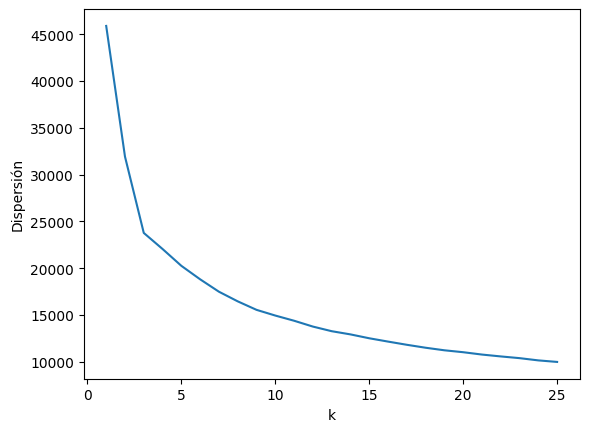

CPU times: user 10.3 s, sys: 393 ms, total: 10.7 s
Wall time: 10.8 s


In [10]:
%%time
import matplotlib.pyplot as plt
max_k = 25
x = [i for i in range(1, max_k + 1)]
y = [calc_dispersion(dataset, i) for i in range(1, max_k + 1)]
plt.plot(x,y)
plt.xlabel("k")
plt.ylabel("Dispersión")
plt.show()

#### c)
Ahora, utilizamos la librería`joblib`para hacer estos 25 cálculos en procesos paralelo

In [18]:
from joblib import Parallel, delayed, externals
externals.loky.set_loky_pickler("cloudpickle")

In [19]:
no_numpy = [delayed(k_medias)(dataset, k) for k in range(1, 25)]
with_numpy = [delayed(k_medias_numpy)(dataset, k) for k in range(1, 25)]

In [26]:
%%time
# Esta celda se estaba demorando demasiado

batch_size = 'auto'
n_jobs = -1
with Parallel(n_jobs=n_jobs, batch_size=batch_size, backend='loky') as parallel_pool:
    parallel_results = parallel_pool(no_numpy)

Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_1536_256ae742ad4549c39a6871c1a8d34878_247af695c9e44b96bdf384dbdb877dd1 for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-1536-5pkugs1m for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {

CPU times: user 718 ms, sys: 156 ms, total: 874 ms
Wall time: 5min 43s


Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_1536_256ae742ad4549c39a6871c1a8d34878_ff23273eac2544cbb3b62c1d6eb9bbc9 for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-1536-sa95m1ib for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {

In [21]:
%%time
batch_size = 'auto'
n_jobs = -1
with Parallel(n_jobs=n_jobs, batch_size=batch_size, backend='loky') as parallel_pool:
    parallel_results = parallel_pool(with_numpy)

Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_1536_d87877b0c6e246139641da03f68747be_439ccd6bb5ec4da6827c281ccbe407a1 for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-1536-sbuhmkfg for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {

CPU times: user 116 ms, sys: 28.4 ms, total: 144 ms
Wall time: 4.62 s


Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_1536_d87877b0c6e246139641da03f68747be_d719814616ed4fe990351ff9ac2b646a for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-1536-faotsc7s for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {

---
### Pregunta 6
#### a)
Mi computador tiene


In [15]:
from joblib import cpu_count
print(cpu_count())

8


núcleos.
#### b y d)
A continuación se presenta un script que mide el tiempo de ejecución de los dos 

n_jobs 1: 9.855538606643677
n_jobs 2: 

Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_1536_0e16ea3dab754f47a1260f0b8e412214_90c866a2eb6e4924aa9d57874eec0b5d for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-1536-kxgdf944 for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {

5.7398693561553955
n_jobs 3: 

Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_1536_0e16ea3dab754f47a1260f0b8e412214_e16d1974e9e444d7a149ce4b6d757c61 for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_1536_fb117de904124cf19da4a1a09e493d8d_425f2572a5bd43a197495d3f54d41854 for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
       

4.798682689666748
n_jobs 4: 

Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_1536_fb117de904124cf19da4a1a09e493d8d_51e6a417bf97447f8f8dca9384c14aab for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_1536_e2c0f814cfea41d3bcbc9d195467b755_2f6798673382418a9e3aa9c6ca73fecb for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
       

3.965766668319702
n_jobs 5: 

Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_1536_fb117de904124cf19da4a1a09e493d8d_d0412c892d1d487c95b76dd879ffb034 for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_1536_769f5fc942794e60bdb04b409ed129e2_d7b748ad559442b79fb1fce8cbc6bb9f for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
       

4.125828504562378
n_jobs 6: 

Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_1536_769f5fc942794e60bdb04b409ed129e2_21e3f97cc4124778b506bb7d9859a055 for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_1536_14c04f424d684d108212e66e315e50a6_c990d1ff741b405e9d473a16307176a7 for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
       

3.232516288757324
n_jobs 7: 

Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_1536_769f5fc942794e60bdb04b409ed129e2_f24df46bfaa34118bc3f6cce53f35f91 for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_1536_b06b11253d5440bf87ba6db18ce4f2a3_e1fb0e4d25064bb1b9100513799dd86b for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
       

3.1870009899139404
n_jobs 8: 

Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_1536_769f5fc942794e60bdb04b409ed129e2_c431952defc8446183f11636cfbd4cad for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_1536_cc6df45cf749485ba9fa831fa5395249_3ce110889f014fd2b134ade3b9498e63 for automatic cleanup: unknown resource type folder
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
       

3.1211159229278564


Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /dev/shm/joblib_memmapping_folder_1536_769f5fc942794e60bdb04b409ed129e2_220cb6fc5f6e497da8b7ff52af745d39 for automatic cleanup: unknown resource type folder


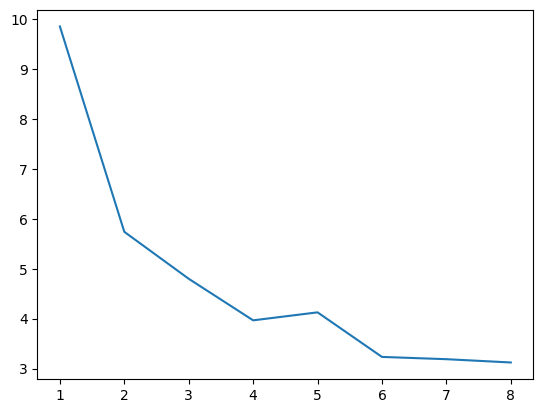

CPU times: user 10.3 s, sys: 266 ms, total: 10.6 s
Wall time: 38.1 s


Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-1536-dw4xveed for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-1536-q1srs9yw for automatic cleanup: unknown resource type semlock
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 295, in main
    raise ValueError(
        f'Cannot register {name} for automatic cleanup: '
        f'unknown resource type {rtype}')
ValueError: Cannot register /loky-1536-pgljkbdu for automatic cleanup: unkn

In [24]:
%%time
from time import time
times_no_numpy, times_numpy = [], []
jobs = [j for j in range(1, 9)]
for j in jobs:
    #print("n_jobs:", n_jobs)
    #print("no numpy")
    #start_no_numpy = time()
    #with Parallel(n_jobs=n_jobs, batch_size=batch_size, backend='loky') as parallel_pool:
    #    parallel_results = parallel_pool(disperssions_no_numpy)
    #end_no_numpy = time() 
    #times_no_numpy.append(end_no_numpy - start_no_numpy)
    
    print("n_jobs", j, end=": ")
    start_numpy = time()
    with Parallel(n_jobs=j, backend='loky', max_nbytes=None) as parallel_pool:
            parallel_results = parallel_pool(with_numpy)
   
    end_numpy = time() 
    total = end_numpy - start_numpy
    times_numpy.append(total)
    print(total)

#plt.plot(jobs, times_no_numpy)
plt.plot(jobs, times_numpy)

plt.show()
    

#### c)
La imagen muestra el output de `htop` cuando vemos el árbol que corresponde al proceso asociado al cuaderno de jupyter. El comando fue corrido cuando se estaba ejecutando la celda anterior y habían 8 trabajadores asignados a la tarea. Efectivamente se observan 8 procesos que corresponden a los _pipes_ utilizados por joblib para ejecutar las 25 tareas en `with_numpy`

![title](P6c.png)

#### e)
Dado lo largo 